Изобразить эпсилон - спектр, эллиптический спектральный портрет с полуосями a=||A||,b=t и соответствующую клеточно диагональную форму матрицы А при с=1, е=10^-3

In [1]:
import numpy as np
import numpy.linalg as la
from matplotlib import pyplot
from mpseudo import pseudo
import math
import matplotlib.pyplot as plt
from pprint import pprint

from IPython.display import HTML, display
import tabulate

In [129]:

# 
c=1
eps=1 #pow(10,-3)



# Создаем матрицу из задания

A=np.zeros((9,9))
for i in [1,4,7]:
    A[i-1][i]=c
    A[i][i-1]=-c
    A[i][i+1]=c
    A[i+1][i]=-c
A[3,2]=eps
A[6,5]=eps
A[2,3]=-eps
A[5,6]=-eps
##########################

#print(la.cond(A))
# Расчет собственных значений
eigen_values=la.eig(A)[0]
eigen_values.imag.sort()
a=la.norm(A)

# Расчитываем эпсилон-спектр 
def f(x,y,A):
    ones=np.zeros((9,9))
    for i in range(0,len(ones)):
        ones[i][i]=1
    res=A-ones.dot(x+1j*y)
    U,S,V=la.svd(res)
    sing_min=S.min()
    return 1/sing_min

# Получаем данные для построения эпсилон спектра
# Делаем данные
X = np.arange(-2.1, 2.1, 0.05)
Y = np.arange(-2.1, 2.1, 0.05)
X, Y = np.meshgrid(X, Y)
Z=[]
for i in range(0,len(X)):
    row=[]
    for j in range(0,len(X[0])):
        row.append(f(X[i,j],Y[i,j],A))
    Z.append(row)
Z=np.asarray(Z)

# Пишем в файл данные для графика эпсилон спектра
# splot "C:\\Users\\Pudov\\Python\\DGLA3\\eps.txt" using 1:2:3 with lines
file = open('eps.txt', 'w')
file.write("# X Y Z"+'\n')
for i in range(0,len(X)):
    for j in range(0,len(X[0])):
        if (Z[i][j]<=200):
            file.write(str(X[i][j])+' '+str(Y[i][j])+' '+str(Z[i][j])+'\n')
file.close()

# Вывод мнимых частей собственных значений в виде таблицы
from IPython.display import HTML, display
import tabulate
table = np.array([eigen_values.imag[:3],eigen_values.imag[3:6],eigen_values.imag[6:9]])
display(HTML(tabulate.tabulate(table, tablefmt='html',floatfmt=(".15f",".15f",".15f"))))

# Вывод действительных частей в виде таблицы
from IPython.display import HTML, display
import tabulate
table = np.array([eigen_values.real[:3],eigen_values.real[3:6],eigen_values.real[6:9]])
display(HTML(tabulate.tabulate(table, tablefmt='html')))




-1.902113032590306,-1.618033988749896,-1.175570504584947
-0.618033988749895,0.000000000000000,0.618033988749895
1.175570504584947,1.618033988749896,1.902113032590306


-1.11022e-16,-1.11022e-16,1.38778e-16
1.38778e-16,1.11732e-30,-2.77556e-17
-2.77556e-17,0,0


In [130]:
# дихотомия единичной окружностью ЧЕРНОВИК
def dichotomy(A0, B0, eps = 1e-3):
    A = A0
    B = B0
    n = A.shape[0]
    n2=int(n/2)
    I = np.eye(n)
    Z = np.zeros((n,n))
    k = 100    
   
    H = I    

    for i in range(0, k):
        
            
        # Строим составную матрицу F
        bF = np.vstack((
                np.hstack((-B, Z, A)), 
                np.hstack((A, -B, Z))))
        # Строим QR разложение
        bQ, bR = la.qr(bF,mode='complete')
    
        # Находим все вспомогательные матрицы
        row1, row2 = np.vsplit(bR, 2)
        F, D, C = np.hsplit(row1, 3)
        zero, B, A = np.hsplit(row2, 3)
        D = -D
        B = -B;
        SA = np.vstack((
                np.hstack((A, -B)),
                np.hstack((I, -I))))
        Sf = np.vstack((Z, I))
        Y0, Y1 = np.vsplit(la.inv(SA).dot(Sf), 2)
        J3 = -la.inv(F).dot(C.dot(Y0)-D.dot(Y1))
        J1 = Y0 - J3
        J2 = J3 - Y1
        Hp = H
        # высчитываем H
        H = J1.dot(H).dot(J1.T) + J2.dot(H).dot(J2.T) + 2. * J3.dot(J3.T)
        if (la.norm(H-Hp) / la.norm(H) < eps):
            break;
        # находим матрицу P
        gA = np.vstack((
          np.hstack((A, -B, Z, Z)),
          np.hstack((Z, -I, I, Z)),
          np.hstack((Z, Z, A, -B)),
          np.hstack((-B, Z, Z, A))))
        gf = np.vstack((Z, I, Z, Z))    
        #temp=la.inv(gA).dot(gf)
        temp=la.solve(gA,gf)
        d, Ptmp,d,  d = np.vsplit(temp, 4)
        P=np.zeros((n2,n2))
        for i in range(0,n2):
            for j in range(0,n2):
                P[i][j]=Ptmp[i][j]+Ptmp[n2+i][n2+j]
    return P, la.norm(H)

def EllipticProj(A,t):
    a = la.norm(A, 2)
    n = A.shape[0]
    I = np.eye(n)
    Z=np.zeros((n,n))
    B = I
    b = t
    
    # замена если a<b
    if (a<b):
        tmp=a
        a=b
        b=tmp
        A=1j*A
    
    # замена для того чтобы разность квадратов была 1.
    k=np.sqrt(pow(a,2)-pow(b,2))
    a=a/k
    b=b/k
    B=k*B
   
    c1 = (a-b)/2;
    c2 = (a+b)/2;
    AA = np.vstack((
            np.hstack(( -c1*B, Z )),
            np.hstack((-A,    -c1*B))))
    AA=AA
    BB = np.vstack((
            np.hstack((c2*B,     A)),
            np.hstack((Z, c2*B))))
    BB=BB
    P, H = dichotomy( AA, BB, eps = 1e-13); 
    return P,H 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: ComplexWarning: Casting complex values to real discards the imaginary part


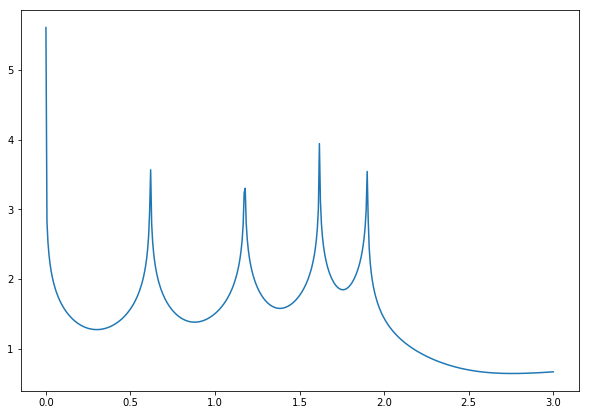

In [131]:

# Эллиптический спектральный портрет
t = np.linspace(0.00001, 3, 500) 
H1 =[]
for ti in t:
    P, H = EllipticProj( A,ti ) 
    H1.append(H)
    
# Печатаем эллиптический спектральный портрет
plt.figure(figsize=(10,7))
plt.plot(t, np.log10(H1))

In [132]:
# Клеточно диагональн форма

#ts = [0.6, 2]
ts=[0.3,0.9,1.4,1.75,2]
I=np.eye(9)
    
n = A.shape[0]
dPs = [ EllipticProj(A,t)[0] for t in ts]

Ps=[dPs[0]+I]
for i in range(1,len(ts)):
     Ps.append(dPs[i]-dPs[i-1])
Ps[len(Ps)-1]=Ps[len(Ps)-1]
ups = []
sps = []

for P in Ps:
    U, S, V = la.svd(P)
    ups.append(U)
    sps.append(S)

cells=[]
for i in range(0,len(Ps)):
    cells.append(ups[i][0:n,0:int(np.trace(Ps[i])+0.1)])


Q = np.hstack(cells)
D = la.inv(Q).dot(A).dot(Q)
D=la.solve(Q,A.dot(Q))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: ComplexWarning: Casting complex values to real discards the imaginary part


In [133]:
# Печатаем след для каждой матрицы P.
for i in range(0,len(Ps)):
    print(int(np.trace(Ps[i])+0.1))

1
2
2
2
2


In [134]:
# Печатаем получившуюся диагональную форму матрицы.
for i in range(0,len(D)):
    for j in range(0,len(D)):
        if D[i][j]<1e-14:
            D[i][j]=0
display(HTML(tabulate.tabulate([np.hsplit(D[i],len(D)) for i in range(0,len(D))],tablefmt='html')))

0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0
0,0.618034,0,0,0,0,0,0,0
0,0,0,0,1.17557,0,0,0,0
0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0
0,0,0,0,0,1.61803,0,0,0
0,0,0,0,0,0,0,0,1.90211
0,0,0,0,0,0,0,0,0


In [ ]:
# дихотомия единичной окружностью
def dichotomy(A0, B0, eps = 1e-3):
    A = A0
    B = B0
    n = A.shape[0]
    n2=int(n/2)
    I = np.eye(n)
    Z = np.zeros((n,n))
    k = 100    
   
    H = I    
  
    for i in range(0, k):
        # Строим составную матрицу F
        bF = np.vstack((
                np.hstack((-B, Z, A)), 
                np.hstack((A, -B, Z))))
        # Строим QR разложение
        bQ, bR = la.qr(bF)
        # Находим все вспомогательные матрицы
        row1, row2 = np.vsplit(bR, 2)
        F, D, C = np.hsplit(row1, 3)
        zero, B, A = np.hsplit(row2, 3)
        D = -D
        B = -B;
        SA = np.vstack((
                np.hstack((A, -B)),
                np.hstack((I, -I))))
        Sf = np.vstack((Z, I))
        Y0, Y1 = np.vsplit(la.inv(SA).dot(Sf), 2)
        J3 = -la.inv(F).dot(C.dot(Y0)-D.dot(Y1))
        J1 = Y0 - J3
        J2 = J3 - Y1
        Hp = H
        # высчитываем H
        H = J1.dot(H).dot(J1.T) + J2.dot(H).dot(J2.T) + 2. * J3.dot(J3.T)
        if (la.norm(H-Hp) / la.norm(H) < eps):
            break;
        # находим матрицу P
        gA = np.vstack((
          np.hstack((A, -B, Z, Z)),
          np.hstack((Z, -I, I, Z)),
          np.hstack((Z, Z, A, -B)),
          np.hstack((-B, Z, Z, A))))
        gf = np.vstack((Z, I, Z, Z))    
        #temp=la.inv(gA).dot(gf)
        temp=la.solve(gA,gf)
        d, Ptmp,d,  d = np.vsplit(temp, 4)
        P=np.zeros((n2,n2))
        for i in range(0,n2):
            for j in range(0,n2):
                P[i][j]=Ptmp[i][j]+Ptmp[n2+i][n2+j]
    return P, la.norm(H)


# Эллиптический спектральный портрет
a = la.norm(A, 2)
t = np.linspace(-3, 3, 500) 
k = len(t)
n = A.shape[0]
I = np.eye(n)
B = I
H1 =[]
Z=np.zeros((n,n))
print(a)
for i in range(0,k):
    b = t[i]
    c1 = (a-b)/2;
    c2 = (a+b)/2;
    AA = np.vstack((
            np.hstack(( -c1*B, Z )),
            np.hstack((-1*np.sign(a-b)*A,    -c1*B))))
    BB = np.vstack((
            np.hstack((c2*B,     A)),
            np.hstack((Z, c2*B))))
    P, H = dichotomy( AA, BB, pow(10,-5) ); 
    H1.append(H)
    
# Печатаем эллиптический спектральный портрет
plt.figure(figsize=(10,7))
plt.plot(t, np.log10(H1))
print(np.max(np.log10(H1)))